<a href="https://colab.research.google.com/github/srikrish2812/pytorch_practice/blob/main/torch_1_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PyTorch Workflow:

1. Prepare the data and load
2. Build the model
3. Fit/Train the model
4. Making the predictions and evaluating the model
5. Saving and loading the model

In [30]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

torch.__version__

'2.5.1+cu121'

## Preparing Data and Loading
- Excel/CSV sheets
- Images
- Videos
- Audio
- DNA
- Text

**We need to transform the data into a numerical representation**

1. We will simulate the data using linear regression formula

In [2]:
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02
X  = torch.arange(start,end,step).unsqueeze(dim=1)
y = weight*X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

## Splitting data into train and test sets

In [3]:
train_split = int(0.8*len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(X_test)

(40, 10)

## Visualize the Data


In [4]:
def plot_predictions(train_data=X_train,
                     train_labels = y_train,
                     test_data = X_test,
                     test_labels = y_test,
                     predictions=None):
    plt.figure(figsize=(9,7))
    # plot the training data
    plt.scatter(train_data, train_labels, c="b",s=4, label="Training data")

    # plot the testing data
    plt.scatter(test_data, test_labels, c="g",s=4, label="Testing data")

    if predictions is not None:
        plt.scatter(test_data, predictions,c="r", s=4, label="Predictions")
    plt.legend(prop={"size":14})

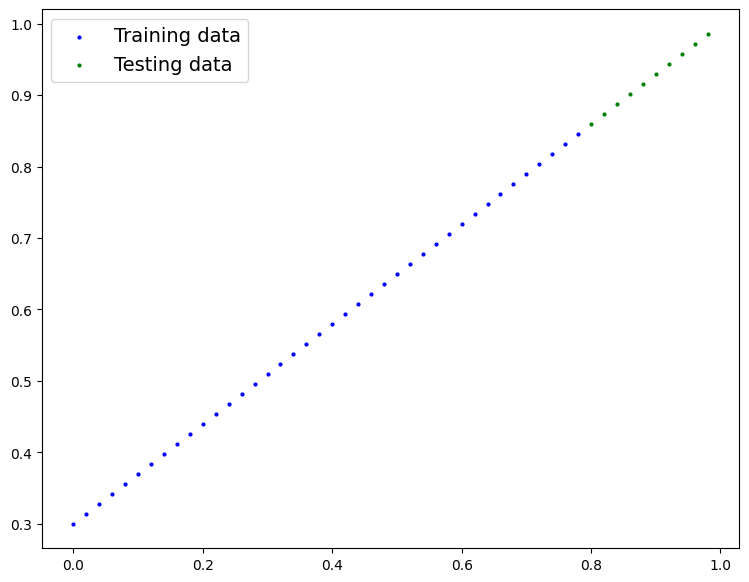

In [5]:
plot_predictions()

## Build the model

In [16]:
class LinearRegressionModel(nn.Module):
    """
    Almost every pytorch model subclasses nn.Module
    """
    def __init__(self):
        super().__init__() # inherits attributes and methods from nn.Module
        self.weights = nn.Parameter(torch.randn(1,requires_grad=True, dtype=torch.float32))
        self.bias = nn.Parameter(torch.randn(1,requires_grad=True, dtype=torch.float32))

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.weights*x + self.bias


### Pytorch model building essentials

- torch.nn: contains the components to build computational graphs. A neural network is a directed acyclic graph
- torch.nn.Parameter - what parameters should our model try and learn, often a PyTorch layer from torch.nn will set these for us
- torch.nn.Module: The base class for all neural network modules, if you subclass it you should overwrite forward()
- torch.optim: diffrent types of optimization algorithms for gradient descent

## Check the model contents

In [32]:
torch.manual_seed(42)

model_0 = LinearRegressionModel()
print(list(model_0.parameters()))
model_0.state_dict()

[Parameter containing:
tensor([0.3367], requires_grad=True), Parameter containing:
tensor([0.1288], requires_grad=True)]


OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making the prediction using `torch.inference_mode()`

- When we pass data thorugh our model it's going to run it trhough the `forward()` method
https://pytorch.org/docs/stable/generated/torch.autograd.grad_mode.inference_mode.html

In [33]:
model_0(X_test)

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]], grad_fn=<AddBackward0>)

In [34]:
# make predictions with model
# with torch.inference removes the gradient tracking as
# it is not required while getting the predictions on the test set since we are not training. There is no need to track gradients
with torch.inference_mode():
    y_preds = model_0(X_test)
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

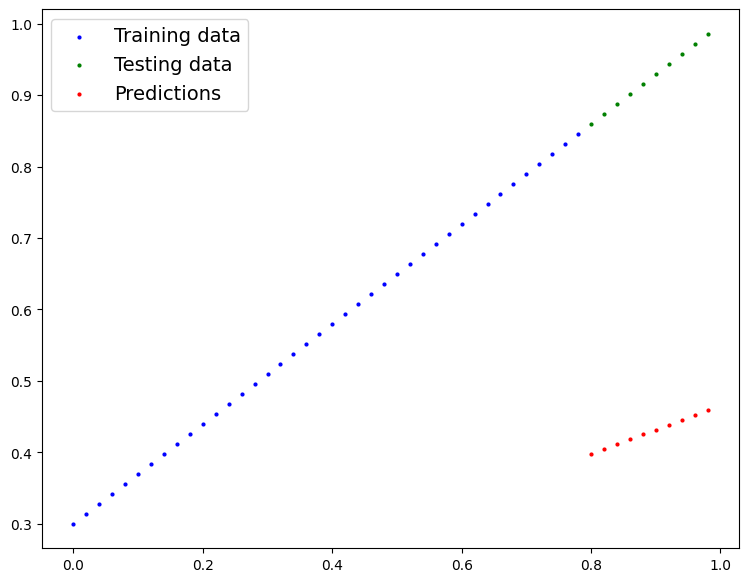

In [35]:
plot_predictions(predictions=y_preds)

## Training Intuition

1. The whole idea of training is for a model to move from some unknown parameters to some known parameters.
2. Or in other words from a poor representation of data to a better represenation
3. A loss function can be used to quantify how wrong a model's predictions are wrt the ground truth values
4. Optimizers take into account the loss of a model and adjusts the model's parameters in the direction of decreasing loss

In [36]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [37]:
# Setup a loss function
loss_fn = nn.L1Loss()

# setup the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr = 0.01)

## Building a training loop and testing loop in PyTorch

0. Loop through the data
1. Forward pass: moving through the model's `forward()` to get the predictions on data
2. Calculate the loss(compare forward pass to ground truth labels)
3. Optimizer zero grad
4. Back Propagation - move backwards through the network to calculate the gradients of loss wrt each parameter
5. Adjust the parameter to reduce the loss iteratively. Use optimizer step

In [41]:
epochs = 200
torch.manual_seed(42)

epoch_count = []
loss_value = []
test_loss_values = []
# 0. looping data
for epoch in range(epochs):
    # set the model to traiing mode
    model_0.train() # train() mode sets all params that requires gradients to require_gradients=True

    # 1. Forward Pass
    y_pred = model_0(X_train)

    # 2. Calculate loss
    loss = loss_fn(y_pred, y_train)
    #print("Loss:",loss)

    # 3. Zero the optimizer gradients
    optimizer.zero_grad()

    # 4. Perform back propagation
    loss.backward()

    # 5. Step the optimizer
    optimizer.step() # how the optimizer changes will accumulate through the loop so we have to zero them in step 3

    # Testing
    model_0.eval() # turns off gradient tracking
    with torch.inference_mode(): # this mode turns off gradient tracking and some more settings
        # 1. Do the forward pass
        test_pred = model_0(X_test)

        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)

    if epoch%10==0:
        epoch_count.append(epoch)
        loss_value.append(np.array(torch.tensor(loss).cpu().numpy()))
        test_loss_values.append(test_loss)
        print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

    print(model_0.state_dict())


<ipython-input-41-a40aa5b7a910>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_value.append(np.array(torch.tensor(loss).cpu().numpy()))


Epoch: 0 | Loss: 0.2783183455467224 | Test loss: 0.44065219163894653
OrderedDict([('weights', tensor([0.3523])), ('bias', tensor([0.1688]))])
OrderedDict([('weights', tensor([0.3562])), ('bias', tensor([0.1788]))])
OrderedDict([('weights', tensor([0.3601])), ('bias', tensor([0.1888]))])
OrderedDict([('weights', tensor([0.3640])), ('bias', tensor([0.1988]))])
OrderedDict([('weights', tensor([0.3679])), ('bias', tensor([0.2088]))])
OrderedDict([('weights', tensor([0.3718])), ('bias', tensor([0.2188]))])
OrderedDict([('weights', tensor([0.3757])), ('bias', tensor([0.2288]))])
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
OrderedDict([('weights', tensor([0.3835])), ('bias', tensor([0.2488]))])
OrderedDict([('weights', tensor([0.3874])), ('bias', tensor([0.2588]))])
Epoch: 10 | Loss: 0.16310831904411316 | Test loss: 0.30594223737716675
OrderedDict([('weights', tensor([0.3913])), ('bias', tensor([0.2688]))])
OrderedDict([('weights', tensor([0.3952])), ('bias', tens

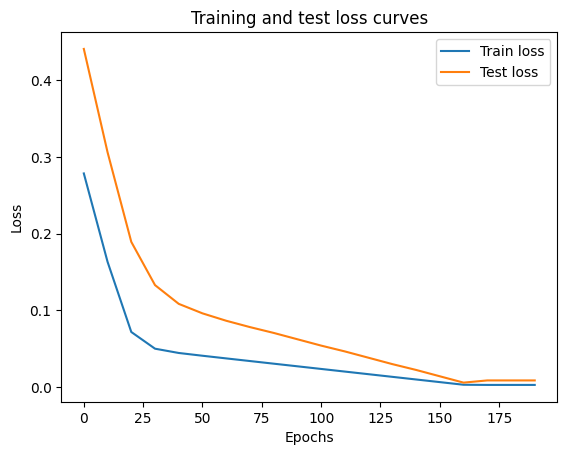

In [43]:
plt.plot(epoch_count, loss_value,label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

In [45]:
with torch.inference_mode():
    y_preds_new = model_0(X_test)

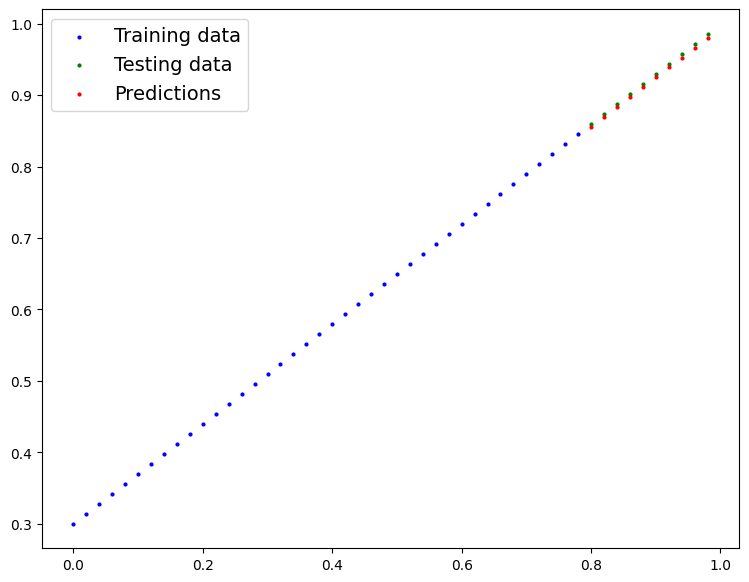

In [46]:
plot_predictions(predictions=y_preds_new)

## Testing Loop

